# Desarrollo M2

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import pandas as pd

import seaborn as sns
sns.set_context(context="notebook")
sns.set_style("ticks")

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from src.data.dataset import lc_dataset
from src.models.model import periodicTransformer, MetricTracker
from src.visualization.plots import plot_periodic
from src.data.curve_generator import random_periodic_sin_mix
from src.utils import get_project_root


/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Objetivos

- [ ] Cambiar el codificador posicional actual (discreto) a uno continuo, puede ser el de T. Sousa o O. Pimentel
- [X] Probar con un conjunto más amplio de clases (curvas sinteticas), por lo que vi tienen dos clases por ahora, traten de extender el problema a almenos 4
- [ ] Realizar pruebas con curvas dobladas (en fase), curvas no dobladas y otras con fase aumentada (esto es simplemente entregar dos fases o tres, una tras la otra)
- [ ] Observar como se comportan los pesos de atención en el caso de series periodicas vs no periodicas, para esto recomiendo que dentro de las 4 clases periodicas que vayan a generar integren una quinta que sea no periodica, sería interesante ver como clasifica esta serie no periodica si el modelo fue entrenado con solo curvas periodicas
- [X] Esto es un poco más libre, pero generar algunas figuras como matrices de confusión, curvas roc, curvas de perdida o accuracy en el tiempo, visualización de el espacio de caracteristicas etc..

## Clasificación de 5 clases

### Generación de datos

In [15]:
train_data = lc_dataset()
train_data.add_curves('sinmix', N=400, seq_len=60, min_period=0.5, max_period=2, label=0, irregular=False)
# train_data.add_curves('sinmix', N=300, seq_len=60, min_period=0.5, max_period=2, label=1, normalize=False)
# train_data.add_curves('sinmix', N=300, seq_len=200, min_period=5, max_period=10, label=1)
train_data.add_curves('sawtooth', N=400, seq_len=60, min_period=1.5, max_period=4, label=1,irregular=False)
train_data.add_curves('square', N=400, seq_len=60, min_period=2, max_period=8, label=2, irregular=False)
# train_data.add_curves('gauss', N=300, seq_len=60, min_period=2, max_period=8, label=4, normalize=False)

val_data = lc_dataset(seed=127)
val_data.add_curves('sinmix', N=100, seq_len=60, min_period=0.5, max_period=2, label=0, irregular=False)
# val_data.add_curves('sinmix', N=150, seq_len=200, min_period=5, max_period=10, label=1, normalize=False)
val_data.add_curves('sawtooth', N=100, seq_len=60, min_period=1.5, max_period=4, label=1, irregular=False)
val_data.add_curves('square', N=100, seq_len=60, min_period=2, max_period=8, label=2, irregular=False)
# val_data.add_curves('gauss', N=150, seq_len=60, min_period=2, max_period=8, label=3)

### Visualización del dataset

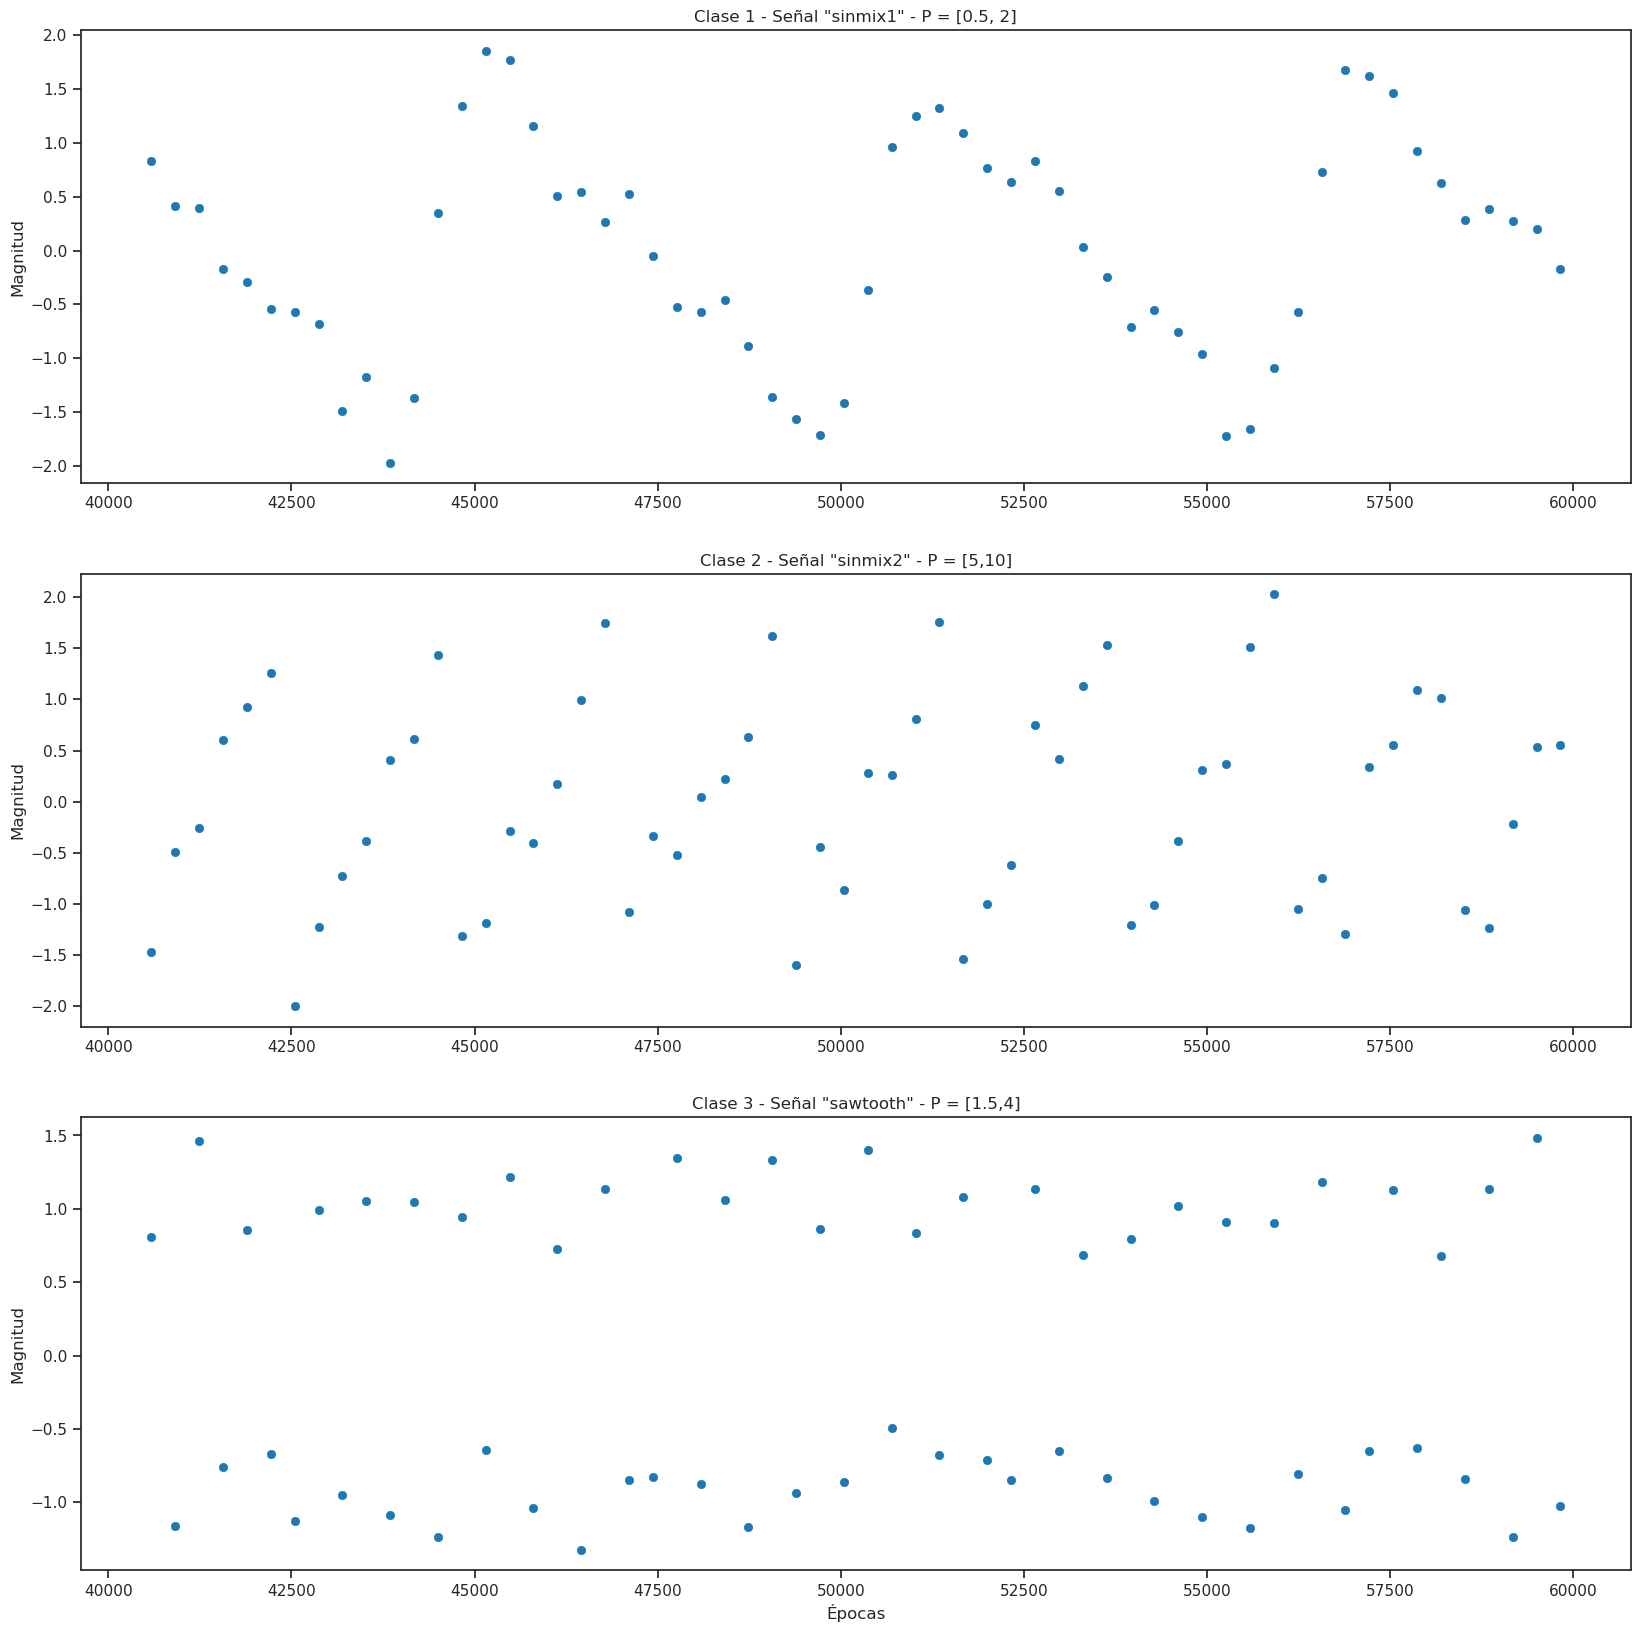

In [16]:
fig, ax = plt.subplots(3, figsize=(20,20))

for label in range(3):
    temp_data = train_data.to_df().loc[train_data.to_df()['label'] == label].iloc[0].copy()
    ax[label].scatter(temp_data.mjd, temp_data.mag, zorder=0.5,linewidth=0.5,alpha=1)
    ax[label].set_ylabel('Magnitud')
ax[0].set_title('Clase 1 - Señal "sinmix1" - P = [0.5, 2]')
ax[1].set_title('Clase 2 - Señal "sinmix2" - P = [5,10]')
ax[2].set_title('Clase 3 - Señal "sawtooth" - P = [1.5,4]')
# ax[3].set_title('Clase 4 - Señal "square" - P = [2,8]')
# ax[4].set_title('Clase 5 - Señal "gauss" - P = --')
plt.xlabel('Épocas')
plt.show()

### Clasificación

#### DataLoaders

In [17]:
batch_size = 128


train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=16,
                            shuffle=True)

val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16)                


#### Generación del modelo

In [18]:
dir_trained_models = get_project_root() / 'models' / 'trained_models'

In [19]:
n_classes = 3

checkpoint_callback = ModelCheckpoint(monitor="val_loss",
                                    dirpath=dir_trained_models,
                                    filename='model',
                                    save_top_k=1,
                                    mode='min')
loss_callback = MetricTracker()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0005)

In [23]:
model = periodicTransformer(n_classes=n_classes, d_model=256, d_ff=512, h=2, N=1)

/home/agonzalez/projects/el7006/Projecto-EL7006/src/models/model.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [24]:
trainer = pl.Trainer(accelerator='gpu',
                    callbacks=[early_stopping, checkpoint_callback, loss_callback],
                    max_epochs=-1,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Training

In [26]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type               | Params
----------------------------------------------------------
0 | pos_enc_discrete   | PositionalEncoding | 0     
1 | pos_enc_continuous | TimeFilm           | 73.0 K
2 | enc_blocks         | ModuleList         | 593 K 
3 | proj               | Linear             | 771   
4 | val_acc            | Accuracy           | 0     
5 | test_f1            | F1Score            | 0     
6 | test_acc           | Accuracy           | 0     
7 | test_recall        | Recall             | 0     
8 | test_precision     | Precision          | 0     
----------------------------------------------------------
667 K     Trainable params
7         Non-trainable params
667 K     Total params
2.669     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 3it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/multiprocessing/queues.py", line 241, in _feed
    close()
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/multiprocessing/queues.py", line 272, in _feed
    queue_sem.release()
Va

ValueError: x and y must have same first dimension, but have shapes (27,) and (29,)

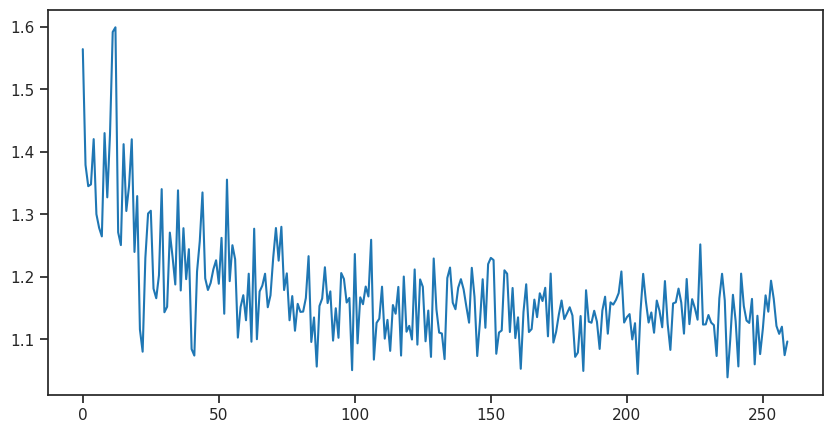

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(loss_callback.loss_history)
ax.plot(np.arange(0, len(loss_callback.loss_history)+1, 10), loss_callback.val_loss_history)
ax.set_title('Loss history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train loss', 'Val loss'])
plt.show()

#### Testing

In [28]:
test_data = lc_dataset(seed=10)
test_data.add_curves('sinmix', N=150, seq_len=60, min_period=0.5, max_period=2, label=0, irregular=False, folded=True)
# test_data.add_curves('sinmix', N=150, seq_len=60, min_period=5, max_period=10, label=1)
test_data.add_curves('sawtooth', N=150, seq_len=60, min_period=1.5, max_period=4, label=1, irregular=False, folded=True)
test_data.add_curves('square', N=150, seq_len=60, min_period=2, max_period=8, label=2, irregular=False, folded=True)
# test_data.add_curves('gauss', N=150, seq_len=60, min_period=2, max_period=8, label=3)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)    

In [29]:
trainer.test(model, test_loader)
# _, test_predictions = trainer.test(model, test_loader)
# test_predictions = np.array(test_predictions)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.40888887643814087
         test_f1            0.40888887643814087
        test_loss           1.0707471555673351
     test_precision         0.40888887643814087
       test_recall          0.40888887643814087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0707471555673351,
  'test_acc': 0.40888887643814087,
  'test_recall': 0.40888887643814087,
  'test_precision': 0.40888887643814087,
  'test_f1': 0.40888887643814087}]

#### Matriz de confusión

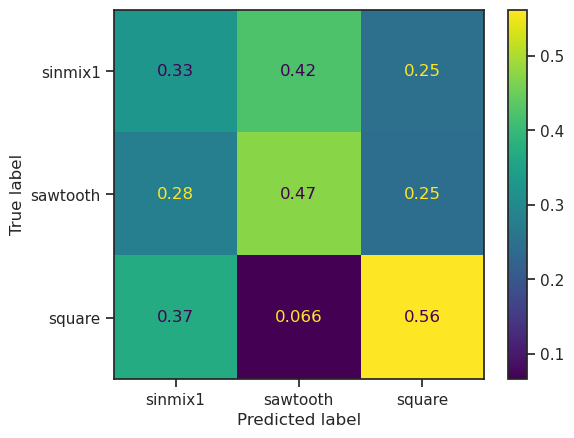

In [30]:
cm = confusion_matrix(
                    model.test_preds,
                    model.test_targ,
                    normalize='true')
disp = ConfusionMatrixDisplay(
                            confusion_matrix=cm,
                            display_labels=[
                                'sinmix1',
                                # 'sinmix2',
                                'sawtooth',
                                'square'])
disp.plot()
plt.show()

#### Otras métricas

In [ ]:
print(
    classification_report(
        model.test_preds,
        model.test_targ,
        target_names=['sinmix1', 'sawtooth', 'square']
        )
        )

## Propuesta a futuro

- Datos con tiempos en distintos intervalos
- Datos con distintos rangos de magnitudes
- Analizar como afecta desbalance